In [1]:
import sys
sys.path.append('../training')

In [2]:
import models
import keras
import numpy as np

2024-08-22 11:39:42.366816: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:39:42.456998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:39:42.556836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 11:39:42.631415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 11:39:42.651513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 11:39:42.793521: I tensorflow/core/platform/cpu_feature_gu

### Load trained model

In [3]:
loaded_model = keras.saving.load_model('1724246652.091741/test_sweep.1.keras', compile=True, custom_objects = {f'mse_of_output_{i}': models.separate_mse(i) for i in range(6)})

/home/aleruzza/UNI/SCIENCE/DBNets/tool_mainversion_git/DBNets/keras3_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/aleruzza/UNI/SCIENCE/DBNets/tool_mainversion_git/DBNets/keras3_env/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'multi_p_model' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(bui

### Load test set

In [9]:
from config import configs
params = configs[0]
params['times'] = [1000]
data = {}
for t in [1000]:
    data[f"time{t}"] = np.load(
        f'../training/{params["data_path"]}/{t}/data.npy', allow_pickle=True
    ).item()

In [10]:
from config import normalize_input_data
import tensorflow as tf
fold = 1

train_inp = np.concatenate(
            [
                np.expand_dims(data[f"time{t}"][f"inp_train{fold}"], axis=3)
                for t in params["times"]
            ],
            axis=0,
        )
train_inp = normalize_input_data(train_inp)
target_train = np.concatenate(
    [
        # this is necessary because labels have been wrongly packed
        np.concatenate(
            [
                data[f"time{t}"][f"targ_train{fold}"].reshape(-1, 6)[i::3]
                for i in range(3)
            ]
        )
        for t in params["times"]
    ],
    axis=0,
)
test_inp = np.concatenate(
    [
        np.expand_dims(data[f"time{t}"][f"inp_test{fold}"], axis=3)
        for t in params["times"]
    ],
    axis=0,
)
test_inp = normalize_input_data(test_inp)

target_test = np.concatenate(
    [data[f"time{t}"][f"targ_test{fold}"] for t in params["times"]], axis=0
)




In [21]:
res = tf.ones((train_inp.shape[0], 1))*0
results = loaded_model(train_inp[100:], training=True, res=res[100:])

### Plot results

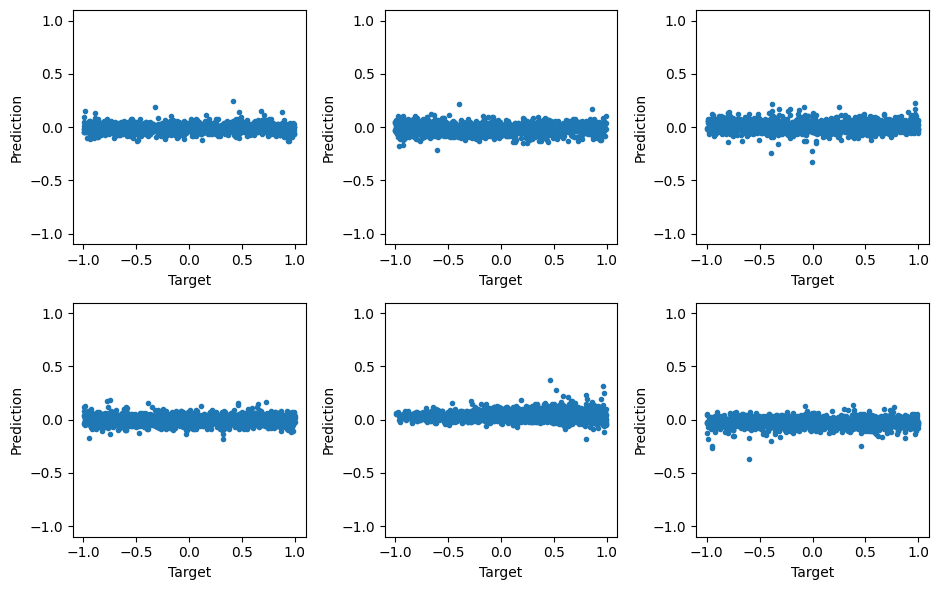

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,3, figsize=(9.5,6))
axs = axs.flatten()
for v in range(6):
    axs[v].scatter(target_train[100:, v], results[:, v], marker='.')
    axs[v].set_xlabel('Target')
    axs[v].set_ylabel('Prediction')
    axs[v].set_xlim(-1.1,1.1)
    axs[v].set_ylim(-1.1,1.1)
plt.tight_layout()

In [23]:
((results-target_train[100:])**2).numpy().mean()

0.32399952